# Assignment 4
## Training a DNN for relation classification

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.


**In this work we will use the hugingface framework for transformers training and inference.**
We recomand reading the documentation in [this](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForSequenceClassification) link *before* you start coding.


All additional packages:

In [ ]:
# !pip install --q
# %pip install --q transformers

All imports: (You may add/change)

In [ ]:
# general
import os
import random
import warnings
from typing import List,Tuple
import pickle


# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn

# HF
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

Set warnings filter to ignore:

In [ ]:
# set warnings filter to ignore:
warnings.filterwarnings("ignore")

Set random SEEDs:

In [ ]:
# set random SEEDs:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Set GPU:

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'
print(f'Using {DEVICE} device')

## Dataset


The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf).
The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)

> Train file: `nlp-course/TRAIN_FILE.TXT`
> Test file: `nlp-course/TEST_FILE_FULL.TXT`


In [ ]:
# !git clone https://github.com/kfirbar/nlp-course

## Task #1

Write a funtion `read_data` for reading the data from a single file (either train or test).

<br>

This function recieves a filepath and returns a list of sentences; Every sentence is encoded as a tuple.

The first element is the sentence string.
The second element is the label (also represented as a sting).

In [ ]:
import re
from typing import List, Tuple

# given a filepath, returns a list of tuples (sentence, label)
def read_data(filepath: str) -> List[Tuple[str, str]]:
    data = []
    with open(filepath, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 4):  # step of 4 because the pattern repeats every 4 lines
            sentence = re.findall(r'"([^"]*)"', lines[i])[0]  # Extracts sentence string between the quotes
            label = lines[i+1].strip()  # Relationship type is on the next line, remove any leading/trailing spaces
            data.append((sentence, label))
    return data

# Define filepaths for your train and test data
train_filepath = "nlp-course/TRAIN_FILE.TXT"
test_filepath = "nlp-course/TEST_FILE_FULL.TXT"
# Read the data (tuple of (sentence, label)
train = read_data(train_filepath)
test = read_data(test_filepath)
# Convert to pandas dataframe
train_df = pd.DataFrame(train, columns=['sentence', 'label'])
test_df = pd.DataFrame(test, columns=['sentence', 'label'])

print('Number of train sentences:', len(train))
print('Number of test sentences:', len(test))


In [ ]:
# print some examples
print('Train examples:')
display(train_df.sample(5))
print('Test examples:')
display(test_df.sample(5))


`Pytorch` require the labels to be integers.

Create a mapper (dictionary) from the string labels to integers (starting zero).
And a dictionary from label to integer.

In [ ]:
def create_label_mapper(data):
  # create a dictionary that maps each id to a label
  id2label = {}
  unique_labels = data['label'].unique()
  for i, label in enumerate(unique_labels):
    id2label[i] = label
  return id2label



# TO DO
id2label = create_label_mapper(train_df)
label2id = {v: k for k, v in id2label.items()}

assert len(id2label) == len(label2id)
print('id2label: \n',id2label)

<br>

Plot the distribution of labels in each dataset.
Display the information in a single plot.

For example:

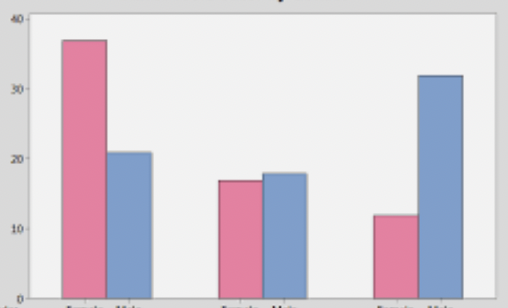

- Use bar plot.
- Use figuresize of (16,6).
- Add titles and Axis names.
- Y-axis will hold the count for each label.
- X-axis will hold the name of each label.

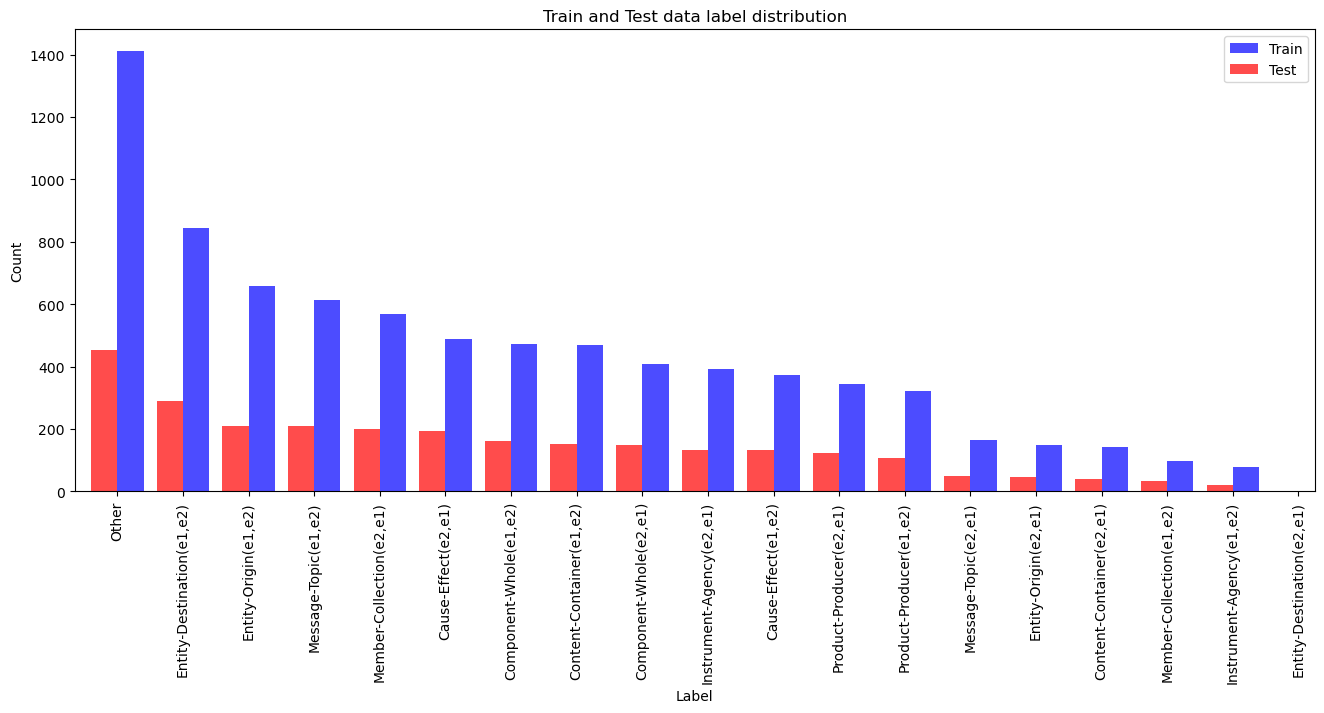

In [184]:
# plot the label distribution in each dataset

# function to plot the distribution of labels in each dataset
def plot_label_distribution(train_data, test_data, title):
    # make a copy of the data so we won't change the original dataframe
    train_data_copy = train_data.copy()
    test_data_copy = test_data.copy()

    # create a figure and axis object
    fig, ax = plt.subplots(figsize=(16, 6))
    # plot the count of each label in the train and test dataset
    train_data_copy['label'].value_counts().plot(kind='bar', ax=ax, color='blue', alpha=0.7, label='Train', position=0, width=0.4)
    test_data_copy['label'].value_counts().plot(kind='bar', ax=ax, color='red', alpha=0.7, label='Test', position=1, width=0.4)

    # set the x and y axis labels and title
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    ax.set_title(title)
    # plot the legend and show the plot
    ax.legend() 
    plt.show()
    # return the unique labels in the train
    return train_data_copy['label'].unique()
    
# call the function to plot the label distribution in the train and test datasets
train_labels = plot_label_distribution(train_df, test_df, 'Train and Test data label distribution')


<br>

<br><br><br><br>


## Task #2

Download the relevant BERT tokenizer.
Use `bert-base-uncased` .


In [ ]:
# TODO
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# TODO: Delete this cell before submitting the notebook, just for testing

# Define a sentence to tokenize
sentence = "The quick brown fox jumps over the lazy dog."

# Tokenize the sentence using the tokenizer
tokens = tokenizer.encode(sentence)
decoded_tokens = tokenizer.decode(tokens)

# Print the token IDs and corresponding tokens
print("Token IDs:", tokens)
print("Tokens:", decoded_tokens)

Write a function `prepare_data` that takes one of the `train & test` datasets and convert each pair of `(words,labels)` to a pair of indexes.

The function also aggregate the samples into batches.

BERT Uses pretrained tokanization and embedding.
you can access the tokanization and indexing using the `BertTokenizer` class.

Note: you may use `torch.utils.data.Dataset`

In [ ]:
import torch.utils.data as data_utils

# given a list of (sentence, label) tuples, returns a list of (tokenized sentence, label_id) tuples
def prepare_data(data, tokenizer, batch_size=8):
    data_sequences = [(tokenizer.encode(sentence), label2id[label]) for sentence, label in data]
    return data_sequences

train_sequences = prepare_data(train, tokenizer)
test_sequences = prepare_data(test, tokenizer)

train_sequences_df = pd.DataFrame(train_sequences, columns=['tokens', 'label_id'])
test_sequences_df = pd.DataFrame(test_sequences, columns=['tokens', 'label_id'])

In [182]:
# print some examples
print('Train examples:')
display(train_sequences_df.sample(5))
print('Test examples:')
display(test_sequences_df.sample(5))

Train examples:


,tokens,label_id
3885,"[101, 1996, 2019, 11636, 28173, 5422, 1026, 10...",5
5578,"[101, 2004, 1037, 2744, 1010, 102]",2
4650,"[101, 1996, 5250, 1026, 1041, 2487, 1028, 3688...",1
4353,"[101, 1998, 2216, 2024, 4364, 2770, 2006, 1996...",14
1998,"[101, 1996, 1026, 1041, 2487, 1028, 9152, 1241...",6


Test examples:


,tokens,label_id
1433,"[101, 1026, 1041, 2487, 1028, 9353, 2638, 1026...",4
2193,"[101, 1996, 1026, 1041, 2487, 1028, 2862, 1026...",10
806,"[101, 1996, 6218, 1015, 2003, 7130, 2058, 1037...",12
950,"[101, 1026, 1041, 2487, 1028, 4683, 1026, 1013...",0
1899,"[101, 1996, 4538, 1026, 1041, 2487, 1028, 5618...",5


<br><br><br><br>

## Task #3

In this part we classify the sentences using the `BertForSequenceClassification` model.


Download the relevant BERT model. Use `bert-base-uncased` .

In [143]:
# TO DO

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(id2label)).to(DEVICE)




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [166]:
# print model layers
print('Model layers:')
for name, param in model.named_parameters():
    print(f'{name} has shape {param.shape}')
    

Model layers:
bert.embeddings.word_embeddings.weight has shape torch.Size([30522, 768])
bert.embeddings.position_embeddings.weight has shape torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight has shape torch.Size([2, 768])
bert.embeddings.LayerNorm.weight has shape torch.Size([768])
bert.embeddings.LayerNorm.bias has shape torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight has shape torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias has shape torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight has shape torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias has shape torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight has shape torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias has shape torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight has shape torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias has shape torch.Size([768])
bert.encoder


Write a function `get_parameters` that gets the model as an input and return the top(final) layer of the model for a `torch` optimizer.

Note: take a look at these links [link1](https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6#:~:text=%3E%3E%3E-,for%20name%2C%20para%20in%20net.named_parameters()%3A,-...%20%20%20%20%20para.requires_grad%20%3D%20False) [link2](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) .


In [168]:
# given a model parameters, returns the parameters of the top (final) layer and the layer before it
def get_parameters(params):
    top_layer_params = []
    for name, param in params:
        if 'classifier' in name: # classifier layer, i.e. the top layer
            top_layer_params.append(param)
            break
        elif 'pooler' in name:
            top_layer_params.append(param)
        elif 'layer.11' in name:
            top_layer_params.append(param)
    return top_layer_params

all_model_params = model.named_parameters()
top_layer_params = get_parameters(all_model_params)


In [169]:
# set requires_grad to False for all parameters except the top layer
for name, param in model.named_parameters():
    param.requires_grad = False

for param in top_layer_params:
    param.requires_grad = True

print('Parameters that will be updated:') 
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

Parameters that will be updated:
bert.encoder.layer.11.attention.self.query.weight
bert.encoder.layer.11.attention.self.query.bias
bert.encoder.layer.11.attention.self.key.weight
bert.encoder.layer.11.attention.self.key.bias
bert.encoder.layer.11.attention.self.value.weight
bert.encoder.layer.11.attention.self.value.bias
bert.encoder.layer.11.attention.output.dense.weight
bert.encoder.layer.11.attention.output.dense.bias
bert.encoder.layer.11.attention.output.LayerNorm.weight
bert.encoder.layer.11.attention.output.LayerNorm.bias
bert.encoder.layer.11.intermediate.dense.weight
bert.encoder.layer.11.intermediate.dense.bias
bert.encoder.layer.11.output.dense.weight
bert.encoder.layer.11.output.dense.bias
bert.encoder.layer.11.output.LayerNorm.weight
bert.encoder.layer.11.output.LayerNorm.bias
bert.pooler.dense.weight
bert.pooler.dense.bias
classifier.weight


Define the optimizer:

- Use the `ADAM` optimizer (from `torch.optim`), which is a fancy version of SGD.
- Use a learning rate of 0.0001.
- Send only the top/final layer of the model to the optimizer (use `top_layer_params`).


In [170]:
# TO DO
optimizer = torch.optim.Adam(top_layer_params, lr=0.0001)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

In [171]:
from torch.nn.utils.rnn import pad_sequence

# Convert the data to PyTorch DataLoader objects
train_dataset = data_utils.TensorDataset(
    pad_sequence([torch.tensor(seq) for seq in train_sequences_df['tokens'].tolist()], batch_first=True),
    torch.tensor(train_sequences_df['label_id'].tolist())
)

test_dataset = data_utils.TensorDataset(
    pad_sequence([torch.tensor(seq) for seq in test_sequences_df['tokens'].tolist()], batch_first=True),
    torch.tensor(test_sequences_df['label_id'].tolist())
)

# split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = data_utils.random_split(train_dataset, [train_size, val_size])

# create the dataloaders
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = data_utils.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [172]:
# test the dataloaders
for batch in train_dataloader:
    input_ids, labels = batch
    print('Input IDs shape:', input_ids.shape)
    print('Labels shape:', labels.shape)
    break


Input IDs shape: torch.Size([16, 141])
Labels shape: torch.Size([16])


<br><br><br><br>

## Task #4

Let's create the trainig function!


1. Write a training function, which takes a the model `BertForSequenceClassification` and number of epochs to train on.

2. Set `criterion` to the `CrossEntropyLoss` (from `torch.nn`) and use the `ADAM` optimizer.

3. Use a simple `for` loop to iterate over the epochs.
Use [tqdm](https://github.com/tqdm/tqdm) to mark your iteration and progress.

Notes:
- You may to split the `train` to `train&dev` sets.
- You may change the input/output of the training function.


In [175]:
def training(model, n_epochs, train_dataloader, dev_dataloader, optimizer, criterion):
    # set the model to train mode initially
    model.train()
    # define history variables to store the train and validation loss
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # iterate through the epochs using the tqdm library to show a progress bar
    for epoch in tqdm(range(n_epochs)):
        # keep track of the training and validation loss
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        # train the model on the training data
        for batch in train_dataloader:
            sentences, labels = batch
            # move the data to GPU if available
            sentences = sentences.to(DEVICE)
            labels = labels.to(DEVICE)
            # clear the gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(sentences)
            # compute the loss
            loss = criterion(outputs.logits, labels)
            # backward pass
            loss.backward()
            # update the parameters
            optimizer.step()
            # update the training loss
            train_loss += loss.item()
            # compute the training accuracy
            _, preds = torch.max(outputs.logits, dim=1)
            train_acc += torch.sum(preds == labels).item()

        # validate the model on the validation data
        for batch in dev_dataloader:
            sentences, labels = batch
            # move the data to GPU if available
            sentences = sentences.to(DEVICE)
            labels = labels.to(DEVICE)
            # turn of the gradients
            with torch.no_grad():
                # forward pass
                outputs = model(sentences)
                # compute the loss
                loss = criterion(outputs.logits, labels)
                # update the validation loss
                val_loss += loss.item()
                # compute the validation accuracy
                _, preds = torch.max(outputs.logits, dim=1)
                val_acc += torch.sum(preds == labels).item()
                
                
        # compute the average training and validation loss
        train_loss = train_loss / len(train_dataloader)
        val_loss = val_loss / len(dev_dataloader)
        # append the loss to the train and validation history
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        # compute the average training and validation accuracy
        train_acc = train_acc / len(train_dataloader.dataset)
        val_acc = val_acc / len(dev_dataloader.dataset)
        # append the accuracy to the train and validation history
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        # print the loss values
        print('Epoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}'.format(
            epoch + 1, n_epochs, train_loss, val_loss, train_acc, val_acc))
    # return the train and validation history
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history



In [176]:
# train the model
train_loss_history, val_loss_history, train_acc_history, val_acc_history = training(model, 30, train_dataloader, val_dataloader, optimizer, loss_fn)

# save the model, train and validation history
torch.save(model.state_dict(), 'model_part_4.pth')
torch.save({
    'train_loss_history': train_loss_history,
    'val_loss_history': val_loss_history,
    'train_acc_history': train_acc_history,
    'val_acc_history': val_acc_history
}, 'model_part_4_history.pth')


  3%|▎         | 1/30 [00:44<21:18, 44.07s/it]

Epoch: 1/30, Train Loss: 1.3242, Val Loss: 1.0736, Train Acc: 0.5339, Val Acc: 0.6031


  7%|▋         | 2/30 [01:28<20:45, 44.49s/it]

Epoch: 2/30, Train Loss: 0.8998, Val Loss: 0.9952, Train Acc: 0.6614, Val Acc: 0.6344


 10%|█         | 3/30 [02:14<20:09, 44.80s/it]

Epoch: 3/30, Train Loss: 0.7402, Val Loss: 0.9162, Train Acc: 0.7056, Val Acc: 0.6581


 13%|█▎        | 4/30 [02:59<19:29, 44.99s/it]

Epoch: 4/30, Train Loss: 0.6297, Val Loss: 0.9457, Train Acc: 0.7392, Val Acc: 0.6512


 17%|█▋        | 5/30 [03:44<18:47, 45.12s/it]

Epoch: 5/30, Train Loss: 0.5268, Val Loss: 0.8757, Train Acc: 0.7719, Val Acc: 0.6650


 20%|██        | 6/30 [04:30<18:04, 45.21s/it]

Epoch: 6/30, Train Loss: 0.4786, Val Loss: 0.9421, Train Acc: 0.7859, Val Acc: 0.6488


 23%|██▎       | 7/30 [05:15<17:21, 45.29s/it]

Epoch: 7/30, Train Loss: 0.3845, Val Loss: 0.9559, Train Acc: 0.8169, Val Acc: 0.6656


 27%|██▋       | 8/30 [06:00<16:37, 45.35s/it]

Epoch: 8/30, Train Loss: 0.3456, Val Loss: 0.9867, Train Acc: 0.8337, Val Acc: 0.6613


 30%|███       | 9/30 [06:46<15:53, 45.41s/it]

Epoch: 9/30, Train Loss: 0.2613, Val Loss: 1.0765, Train Acc: 0.8550, Val Acc: 0.6525


 33%|███▎      | 10/30 [07:32<15:09, 45.46s/it]

Epoch: 10/30, Train Loss: 0.2569, Val Loss: 1.1198, Train Acc: 0.8625, Val Acc: 0.6687


 37%|███▋      | 11/30 [08:17<14:24, 45.50s/it]

Epoch: 11/30, Train Loss: 0.2113, Val Loss: 1.1400, Train Acc: 0.8753, Val Acc: 0.6550


 40%|████      | 12/30 [09:03<13:39, 45.53s/it]

Epoch: 12/30, Train Loss: 0.1829, Val Loss: 1.1581, Train Acc: 0.8842, Val Acc: 0.6650


 43%|████▎     | 13/30 [09:48<12:54, 45.56s/it]

Epoch: 13/30, Train Loss: 0.1710, Val Loss: 1.1202, Train Acc: 0.8897, Val Acc: 0.6731


 47%|████▋     | 14/30 [10:34<12:09, 45.58s/it]

Epoch: 14/30, Train Loss: 0.1629, Val Loss: 1.1966, Train Acc: 0.8917, Val Acc: 0.6631


 50%|█████     | 15/30 [11:19<11:23, 45.55s/it]

Epoch: 15/30, Train Loss: 0.1510, Val Loss: 1.1767, Train Acc: 0.8944, Val Acc: 0.6631


 53%|█████▎    | 16/30 [12:05<10:36, 45.46s/it]

Epoch: 16/30, Train Loss: 0.1313, Val Loss: 1.2255, Train Acc: 0.9022, Val Acc: 0.6781


 57%|█████▋    | 17/30 [12:50<09:49, 45.38s/it]

Epoch: 17/30, Train Loss: 0.1189, Val Loss: 1.3627, Train Acc: 0.9050, Val Acc: 0.6556


 60%|██████    | 18/30 [13:35<09:03, 45.30s/it]

Epoch: 18/30, Train Loss: 0.1203, Val Loss: 1.3439, Train Acc: 0.9052, Val Acc: 0.6519


 63%|██████▎   | 19/30 [14:20<08:17, 45.23s/it]

Epoch: 19/30, Train Loss: 0.0943, Val Loss: 1.3509, Train Acc: 0.9134, Val Acc: 0.6675


 67%|██████▋   | 20/30 [15:05<07:31, 45.17s/it]

Epoch: 20/30, Train Loss: 0.1068, Val Loss: 1.4263, Train Acc: 0.9086, Val Acc: 0.6625


 70%|███████   | 21/30 [15:50<06:46, 45.12s/it]

Epoch: 21/30, Train Loss: 0.1031, Val Loss: 1.3974, Train Acc: 0.9092, Val Acc: 0.6556


 73%|███████▎  | 22/30 [16:35<06:00, 45.08s/it]

Epoch: 22/30, Train Loss: 0.0938, Val Loss: 1.3208, Train Acc: 0.9127, Val Acc: 0.6725


 77%|███████▋  | 23/30 [17:20<05:15, 45.05s/it]

Epoch: 23/30, Train Loss: 0.0817, Val Loss: 1.4405, Train Acc: 0.9183, Val Acc: 0.6606


 80%|████████  | 24/30 [18:05<04:29, 44.97s/it]

Epoch: 24/30, Train Loss: 0.0885, Val Loss: 1.4317, Train Acc: 0.9161, Val Acc: 0.6675


 83%|████████▎ | 25/30 [18:48<03:42, 44.44s/it]

Epoch: 25/30, Train Loss: 0.0837, Val Loss: 1.3248, Train Acc: 0.9153, Val Acc: 0.6863


 87%|████████▋ | 26/30 [19:30<02:54, 43.67s/it]

Epoch: 26/30, Train Loss: 0.0925, Val Loss: 1.3915, Train Acc: 0.9145, Val Acc: 0.6663


 90%|█████████ | 27/30 [20:12<02:09, 43.12s/it]

Epoch: 27/30, Train Loss: 0.0849, Val Loss: 1.5016, Train Acc: 0.9164, Val Acc: 0.6619


 93%|█████████▎| 28/30 [20:54<01:25, 42.73s/it]

Epoch: 28/30, Train Loss: 0.0906, Val Loss: 1.4301, Train Acc: 0.9156, Val Acc: 0.6669


 97%|█████████▋| 29/30 [21:35<00:42, 42.45s/it]

Epoch: 29/30, Train Loss: 0.0616, Val Loss: 1.4716, Train Acc: 0.9244, Val Acc: 0.6631


100%|██████████| 30/30 [22:17<00:00, 44.59s/it]

Epoch: 30/30, Train Loss: 0.0771, Val Loss: 1.4229, Train Acc: 0.9177, Val Acc: 0.6750


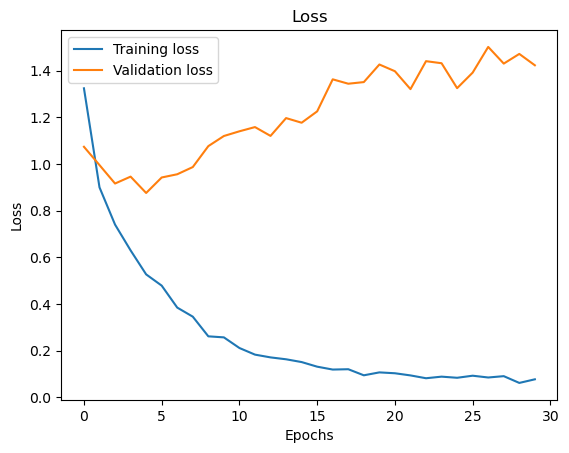

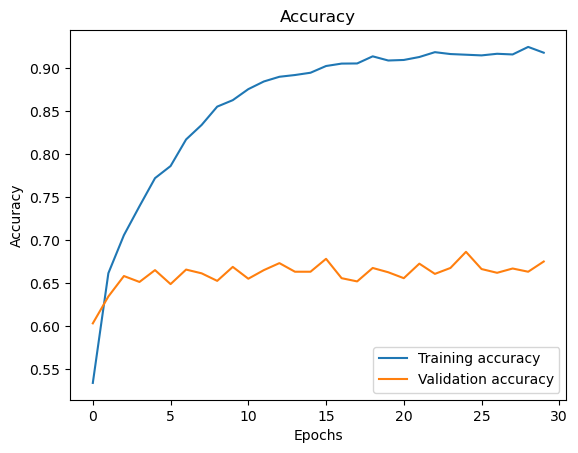

In [179]:
# plot the training and validation loss
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.plot(train_acc_history, label='Training accuracy')
plt.plot(val_acc_history, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



<br><br><br><br>

## Task #5

Write an evaluation loop on a trained model, using the test dataset.

Instructions:
> Input: model, data
> Output: Report, Confusion matrix

> 1. Display: Report, Confusion matrix
> 2. Save: a csv report


Explanation:
This function will perform an evaluation over a model with a dataset.
Calculate the `PERCISION, RECALL, F1` scores of each label seperately, and display them in a table.

Display a confusion matrix plot: where the predicted labels are the rows, and the true labels are the columns.


In addition, load thwe report to a dataframe and save to a CSV with this name:

> `{student_id_1}_{student_id_n}_part5.csv`
For example: `300123123_200456789_part_5.csv`



In [214]:
from sklearn.metrics import classification_report, confusion_matrix


cols   = ['PERCISION','RECALL','F1','SUPPORT']
# old labels, not used
labels_OG = ['Other', 'Cause-Effect', 'Component-Whole', 'Content-Container', 'Entity-Destination', 'Entity-Origin', 'Instrument-Agency', 'Member-Collection', 'Message-Topic', 'Product-Producer']


# given model and test data, return Report (Persicion, Recall, F1, Support) and Confusion Matrix
def evaluate(model, test_dataloader):
  model.eval()
  y_true = []
  y_pred = []
  with torch.no_grad():
    for batch in test_dataloader:
      sentences, labels = batch
      sentences = sentences.to(DEVICE)
      labels = labels.to(DEVICE)
      outputs = model(sentences)
      _, preds = torch.max(outputs.logits, dim=1)
      preds = preds.tolist()
      labels = labels.tolist()
      y_true.extend(labels)
      y_pred.extend(preds)

  return y_pred, y_true   



# evaluate the model on the test data
y_pred , y_true = evaluate(model, test_dataloader)



# display()
# save()

num of labels: 19
{'Component-Whole(e2,e1)': 0, 'Other': 1, 'Instrument-Agency(e2,e1)': 2, 'Member-Collection(e1,e2)': 3, 'Cause-Effect(e2,e1)': 4, 'Entity-Destination(e1,e2)': 5, 'Content-Container(e1,e2)': 6, 'Message-Topic(e1,e2)': 7, 'Product-Producer(e2,e1)': 8, 'Member-Collection(e2,e1)': 9, 'Entity-Origin(e1,e2)': 10, 'Cause-Effect(e1,e2)': 11, 'Component-Whole(e1,e2)': 12, 'Message-Topic(e2,e1)': 13, 'Product-Producer(e1,e2)': 14, 'Entity-Origin(e2,e1)': 15, 'Content-Container(e2,e1)': 16, 'Instrument-Agency(e1,e2)': 17, 'Entity-Destination(e2,e1)': 18}
labels: ['Component-Whole(e2,e1)', 'Other', 'Instrument-Agency(e2,e1)', 'Member-Collection(e1,e2)', 'Cause-Effect(e2,e1)', 'Entity-Destination(e1,e2)', 'Content-Container(e1,e2)', 'Message-Topic(e1,e2)', 'Product-Producer(e2,e1)', 'Member-Collection(e2,e1)', 'Entity-Origin(e1,e2)', 'Cause-Effect(e1,e2)', 'Component-Whole(e1,e2)', 'Message-Topic(e2,e1)', 'Product-Producer(e1,e2)', 'Entity-Origin(e2,e1)', 'Content-Container(e2,e1)

In [235]:

def get_report(y_pred, y_true, labels):
  report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
  report = pd.DataFrame(report).transpose()
  report = report[cols]
  return report

def get_cm_matrix(y_pred, y_true, labels):
  matrix = confusion_matrix(y_true, y_pred, labels=labels)
  matrix = pd.DataFrame(matrix, index=labels, columns=labels)
  return matrix

y_pred: [7, 8, 2, 5, 4, 12, 1, 1, 12, 7, 5, 14, 5, 1, 10, 10, 5, 1, 9, 14, 7, 6, 14, 3, 15, 14, 1, 1, 12, 10, 11, 7, 12, 4, 12, 12, 9, 16, 3, 4, 1, 2, 7, 5, 10, 6, 6, 5, 1, 7, 5, 12, 9, 9, 11, 10, 5, 11, 14, 12, 15, 14, 2, 3, 5, 8, 1, 1, 7, 14, 1, 10, 4, 10, 1, 13, 1, 2, 5, 8, 12, 12, 11, 12, 7, 2, 7, 8, 15, 7, 10, 8, 6, 12, 1, 1, 7, 8, 5, 7, 7, 2, 1, 7, 4, 7, 4, 11, 14, 9, 7, 6, 1, 8, 11, 4, 14, 5, 9, 17, 5, 2, 1, 1, 7, 10, 3, 11, 1, 6, 11, 7, 12, 1, 6, 1, 9, 9, 10, 3, 17, 10, 1, 10, 3, 2, 6, 1, 2, 8, 14, 9, 9, 7, 7, 8, 12, 1, 11, 13, 7, 10, 10, 1, 5, 6, 9, 12, 10, 2, 5, 3, 10, 13, 4, 14, 5, 10, 2, 8, 5, 5, 2, 8, 6, 9, 5, 8, 13, 1, 11, 7, 7, 7, 13, 11, 15, 1, 5, 10, 12, 6, 3, 4, 5, 12, 2, 16, 9, 9, 12, 10, 6, 2, 15, 16, 6, 9, 4, 1, 6, 1, 7, 13, 1, 1, 6, 9, 14, 2, 10, 9, 1, 4, 14, 4, 1, 12, 11, 4, 15, 6, 12, 1, 11, 8, 6, 12, 10, 5, 12, 10, 11, 12, 1, 1, 4, 14, 2, 1, 7, 5, 15, 13, 4, 5, 7, 9, 1, 1, 9, 1, 13, 9, 4, 5, 7, 2, 14, 1, 3, 5, 7, 5, 7, 6, 9, 4, 1, 7, 5, 7, 12, 1, 10, 10, 5, 5, 

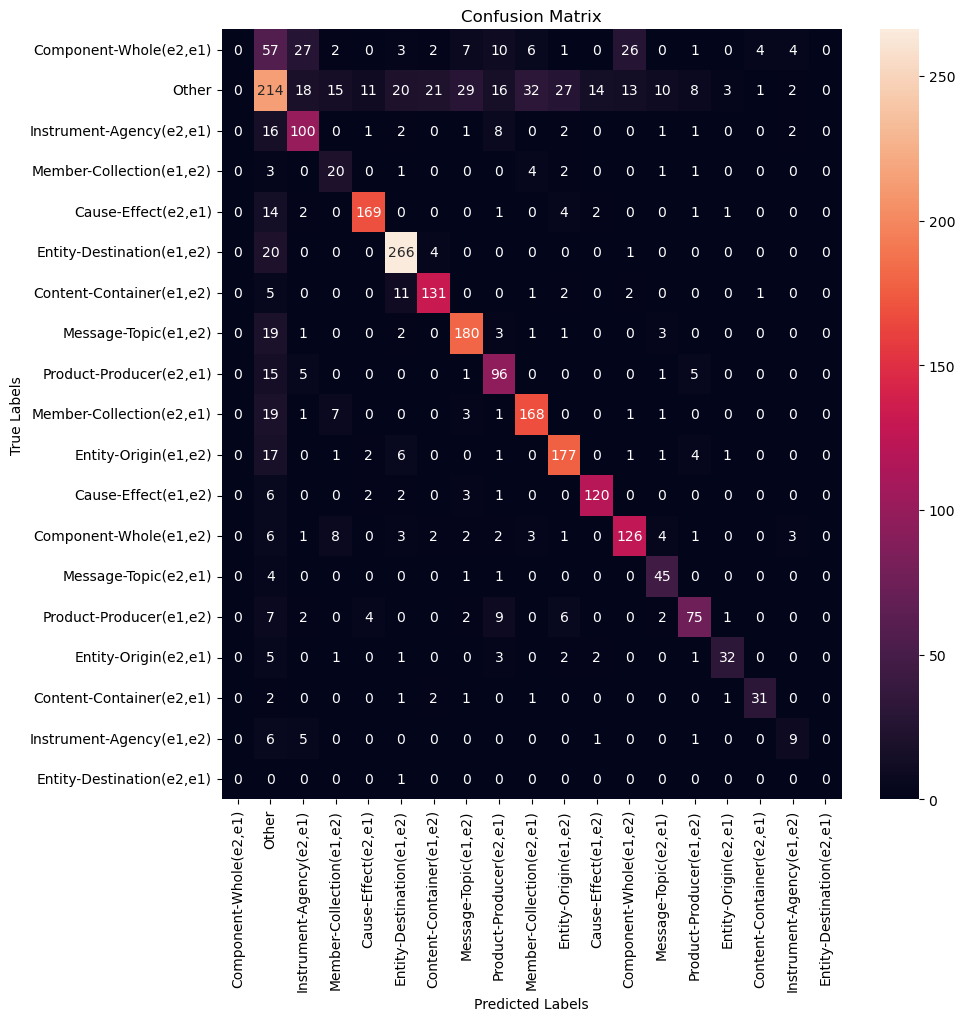

KeyError: "None of [Index(['PERCISION', 'RECALL', 'F1', 'SUPPORT'], dtype='object')] are in the [columns]"

In [236]:
print('y_pred:', y_pred)
print('y_true:', y_true)
# convert the labels from id to name
y_pred_str = [id2label[i] for i in y_pred]
y_true_str = [id2label[i] for i in y_true]

print('y_pred_str:', y_pred_str)
print('y_true_str:', y_true_str)
# compute confusion matrix
cm_matrix = get_cm_matrix(y_pred_str, y_true_str, list(label2id.keys()))
# plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# compute classification report
report = get_report(y_pred_str, y_true_str, labels)



In [ ]:
# Example:
# results_acc = np.random.rand(10, 4)
# df = pd.DataFrame(results_acc,columns=cols)
# df.index = labels
# print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

<br><br><br><br>

## Task #6

In this part we'll improve the model accuracy by using a method called "entity markers - Entity start".

The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. Instead of using the `CLS token` for clasification, we will use the concatination of the embedding of `[e1]` and `[e2]` as shown in the image below.

The complete method is described in details in the paper [Matching the Blanks: Distributional Similarity for Relation Learning following](https://arxiv.org/pdf/1906.03158.pdf) (specifically in Section 3.2).

 To use this method we'll need to create a new data load and a new model.

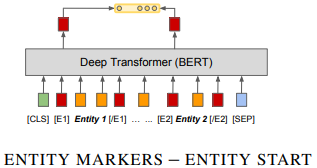

The new methods require the usage of special tokens.
Fix the following code so it will add the required tokens:

In [ ]:
E1_START = '<e1>'
E1_END   = '</e1>'
E2_START = '<e2>'
E2_END   = '</e2>'

# TO DO
new_tokens = []
mtb_tokenizer = None
mtb_tokenizer.add_tokens(new_tokens)

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

Note: you may change the classes, function, etc.

In [ ]:
# TO DO
class MTBRCDataset(torch.utils.data.Dataset):
  def __init__(self):
    super(MTBRCDataset, self).__init__()


In [ ]:
# TO DO

def prepare_data_MTB(data, tokenizer, batch_size=8):
    data_sequences = []
    # TO DO

    return data_sequences

# Example
# train_sequences = prepare_data_MTB(train, tokenizer)
# test_sequences = prepare_data_MTB(test, tokenizer)

mtb_train_dl = None
mtb_dev_dl = None
mtb_test_dl = None

In [ ]:
print(len(mtb_train_dl),len(mtb_dev_dl),len(mtb_test_dl))

Create a new model that uses the "entity markers - Entity start" method.

In [ ]:
class MTB(nn.Module):

    def __init__(self, base_model_name):
      config = AutoConfig.from_pretrained(name)
      self.model = AutoModel.from_config(config)
      # TO DO

    def forward(self, input, index):
      # TO DO

model = MTB('bert-base-uncased')

Use the new dataloader and model to train the new model as in task 4.



**Evaluation**

Use the new dataloader and model to evaluate the new model as in task 5.
> 1. Display: Report, Confusion matrix
> 2. Save: a csv report

Use this format:
> `{student_id_1}_{student_id_n}_part6.csv`
> For example: `300123123_200456789_part_6.csv`


In [ ]:
# TO DO

training(model, n_epochs, train_data, dev_data)
evaluate(model, test_data)

# display()
# save()

<br><br><br><br><br>

## Task 7

In  this final task we will classify similar sentences (1 - similar, 0 - not similar).
We will use an `off the shelf model` and run inference.

- Get the kaggle dataset and create a inference pipeline for the Sentence similarity. Use an off-the-shelf.

Note: you may add change cells as you pleased.


Optional: Clear GPU space if needed

In [ ]:
# TO DO


Set all the relavant random seed to 111

In [ ]:
# TO DO


Download the `train` dataset from [here](https://github.com/saharmilis/runi-nlp/tree/main/kaggle).

In [ ]:
# TO DO


Download the sentence similarty tokenizer & model `all-mpnet-base-v2`.
Here the [link](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) to the model.



In [ ]:
# TO DO


Run inference on the **first 5K lines** in the train dataset, and save it in a dataframe.

In [ ]:
df_t7 = pd.DataFrame(columns=['ID','LABEL_TRUE','LABEL_PRED'])

# TO DO


Print a classification report (use a simple SK-learn classification report)

In [ ]:
# TO DO


Save a CSV file as `{student_id_1}_{student_id_n}_part7.csv` with this format: `ID, LABEL_TRUE, LABEL_PRED`

Notice:
- Do not write the index number to the CSV file.
- Make sure the CSV file will contain only integers.


In [ ]:
# TO DO


<br><br><br><br><br><br>
**Good luck!**